In [1]:
# importing packages

import numpy as np
import os
import time
from dask import dataframe as dd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import vitaldb
import csv
from datetime import datetime, time as datetime_time, timedelta
import glob
import sys
import sklearn.neighbors._base
import vitaldb
import itertools

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

In [3]:
def getRootDir():
    """
    Get root folder directory
    :return: root folder directory
    :rtype: path
    """
    rootdir = os.path.abspath(os.curdir)

    return rootdir
rootdir = getRootDir()
rootdir

'/Users/tselanna/Desktop/Code'

In [4]:
# Import dataset
df = glob.glob(os.path.join(
        rootdir, 'TOSHIBA_HDD/2022_07_15T18_01_25_ANALYSIS_DF_44var.csv'))
df = pd.read_csv(df[0], dtype={"Solar8000/BT": float})

In [5]:
 ids = [21,   30,   50,  116,  133,  207,  220,  238,  239,  243,  269,
        313,  320,  323,  329,  459,  476,  487,  489,  606,  696,  782,
        832,  865,  927,  930,  939,  965,  978, 1021, 1104, 1137, 1236,
       1244, 1405, 1492, 1494, 1499, 1502, 1508, 1591, 1666, 1718, 1741,
       1764, 1767, 1826, 1965, 2082, 2094, 2201, 2247, 2248, 2302, 2306,
       2308, 2363, 2371, 2431, 2462, 2549, 2588, 2617, 2634, 2779, 2792,
       2800, 2863, 2881, 2928, 2934, 2936, 2937, 2957, 3052, 3059, 3161,
       3183, 3195, 3227, 3283, 3326, 3356, 3358, 3431, 3449, 3494, 3496,
       3532, 3546, 3557, 3562, 3597, 3670, 3714, 3732, 3754, 3761, 3780,
       3823, 3851, 3918, 3920, 3924, 3933, 4028, 4154, 4160, 4248, 4257,
       4303, 4354, 4363, 4366, 4378, 4517, 4657, 4670, 4691, 4709, 4773,
       4829, 4840, 4848, 4897, 4898, 4970, 4972, 5011, 5017, 5086, 5128,
       5187, 5196, 5198, 5211, 5263, 5297, 5318, 5345, 5400, 5465, 5494,
       5523, 5555, 5631, 5644, 5731, 5734, 5756, 5798, 5828, 5834, 5881,
       5888, 5900, 5935, 6001, 6112, 6118, 6123, 6225, 6226, 6263, 6265,
       6325, 6340, 6352, 6360]

In [6]:
len(ids)

169

In [7]:
isin = df.loc[df['caseid'].isin(ids)]

In [8]:
# shrink dataset to the first 6 cases 
caseids = isin.caseid.unique()
caseids


array([  21,   30,   50,  116,  133,  207,  220,  238,  239,  243,  269,
        313,  320,  323,  329,  459,  476,  487,  489,  606,  696,  782,
        832,  865,  927,  930,  939,  965,  978, 1021, 1104, 1137, 1236,
       1244, 1405, 1492, 1494, 1499, 1502, 1508, 1591, 1666, 1718, 1741,
       1764, 1767, 1826, 1965, 2082, 2094, 2201, 2247, 2248, 2302, 2306,
       2308, 2363, 2371, 2431, 2462, 2549, 2588, 2617, 2634, 2779, 2792,
       2800, 2863, 2881, 2928, 2934, 2936, 2937, 2957, 3052, 3059, 3161,
       3183, 3195, 3227, 3283, 3326, 3356, 3358, 3431, 3449, 3494, 3496,
       3532, 3546, 3557, 3562, 3597, 3670, 3714, 3732, 3754, 3761, 3780,
       3823, 3851, 3918, 3920, 3924, 3933, 4028, 4154, 4160, 4248, 4257,
       4303, 4354, 4363, 4366, 4378, 4517, 4657, 4670, 4691, 4709, 4773,
       4829, 4840, 4848, 4897, 4898, 4970, 4972, 5011, 5017, 5086, 5128,
       5187, 5196, 5198, 5211, 5263, 5297, 5318, 5345, 5400, 5465, 5494,
       5523, 5555, 5631, 5644, 5731, 5734, 5756, 57

In [9]:
# only keep MBP variable
data = isin[["Solar8000/NIBP_MBP", 'caseid']].copy()

## Preprocessing

In [10]:
MINUTES_AHEAD = 5  # Predict hypotension 1 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 64  # Batch size for learning
MAX_CASES = 600  # Maximum number of cases for this example

In [11]:
# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure 

    a = data.loc[data.caseid.eq(caseid)]
    b = a[['Solar8000/NIBP_MBP']].values.tolist()
    mbps= list(itertools.chain.from_iterable(b))
    

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(mbps)
    case_sample = 0
    case_event = 0
    for i in range(0, len(mbps) - (150 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 150]
        segy = mbps[i + 150 + MINUTES_AHEAD * 30:i + 150 + MINUTES_AHEAD * 30 + 30]
        
        valid = True
        valid_mask.append(valid)
        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        c.append(caseid)
        
        if evt:
            case_event += 1
   
        if valid:
            case_sample += 1
            if evt:
                case_event += 1
    
    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no samples')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x = x[...,None]  # add 3rd axis for input of LSTM

print(x.shape)
print(y.shape)

loading 21...5552 samples 0 (0.0 %) events
loading 30...4875 samples 2482 (50.9 %) events
loading 50...1815 samples 734 (40.4 %) events
loading 116...577 samples 4 (0.7 %) events
loading 133...4650 samples 564 (12.1 %) events
loading 207...4373 samples 0 (0.0 %) events
loading 220...4143 samples 850 (20.5 %) events
loading 238...5443 samples 86 (1.6 %) events
loading 239...1822 samples 0 (0.0 %) events
loading 243...1444 samples 0 (0.0 %) events
loading 269...1615 samples 0 (0.0 %) events
loading 313...4554 samples 0 (0.0 %) events
loading 320...3933 samples 96 (2.4 %) events
loading 323...2131 samples 1356 (63.6 %) events
loading 329...3814 samples 0 (0.0 %) events
loading 459...4974 samples 0 (0.0 %) events
loading 476...2385 samples 0 (0.0 %) events
loading 487...3542 samples 306 (8.6 %) events
loading 489...2939 samples 394 (13.4 %) events
loading 606...3821 samples 0 (0.0 %) events
loading 696...3863 samples 0 (0.0 %) events
loading 782...7883 samples 362 (4.6 %) events
loading 83

## Splitting samples into training and testing dataset

In [12]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set test set 
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask]
train_y_valid = y[train_mask]
test_x_valid = x[test_mask]
test_y_valid = y[test_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'600cases 5ahead batchsize=64 total 657661, train 511715 (31105 events 6.1%), test 145946 (9065 events 6.2%)'

## Model building and training

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [14]:
# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

2022-08-15 10:12:46.957095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
4606/4606 [==============================] - ETA: 0s - loss: 0.4733 - accuracy: 0.8949 - auc: 0.8660
Epoch 1: val_loss improved from inf to 0.34272, saving model to output/weights.hdf5
4606/4606 [==============================] - 265s 57ms/step - loss: 0.4733 - accuracy: 0.8949 - auc: 0.8660 - val_loss: 0.3427 - val_accuracy: 0.8420 - val_auc: 0.8215
Epoch 2/100
4606/4606 [==============================] - ETA: 0s - loss: 0.4616 - accuracy: 0.8952 - auc: 0.8738
Epoch 2: val_loss improved from 0.34272 to 0.30408, saving model to output/weights.hdf5
4606/4606 [==============================] - 308s 67ms/step - loss: 0.4616 - accuracy: 0.8952 - auc: 0.8738 - val_loss: 0.3041 - val_accuracy: 0.8635 - val_auc: 0.8179
Epoch 3/100
4606/4606 [==============================] - ETA: 0s - loss: 0.4605 - accuracy: 0.8934 - auc: 0.8745
Epoch 3: val_loss improved from 0.30408 to 0.25897, saving model to output/weights.hdf5
4606/4606 [==============================] - 371s 81ms/step - los

2127

## Evaluation of the model performance

In [15]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

In [16]:
# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)



4561/4561 [==============================] - 101s 22ms/step
auroc=0.798, auprc=0.209 acc=0.882, F1=0.310, PPV=24.3, NPV=96.0, TN=124822, fp=12059, fn=5193, TP=3872


In [17]:
auroc

0.7980645973028302

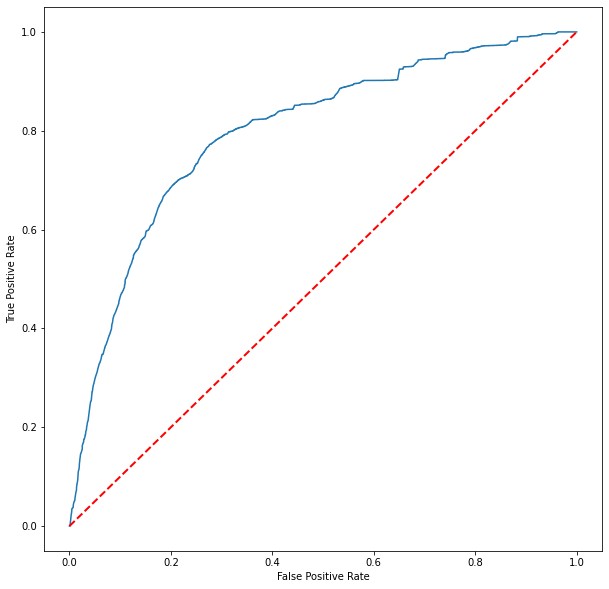

<function matplotlib.pyplot.show(close=None, block=None)>

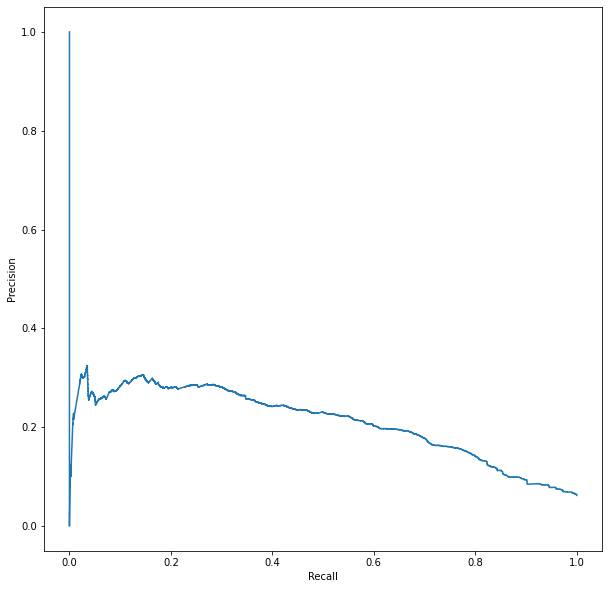

In [18]:
# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig('{}/auroc.png'.format(tempdir))
# plt.close()
plt.show()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.savefig('{}/auprc.png'.format(tempdir))
# plt.close()
plt.show


## Plotting each case in the test dataset

145/145 [==============================] - 2s 12ms/step
Print error: 5263	0.21513799112006896	


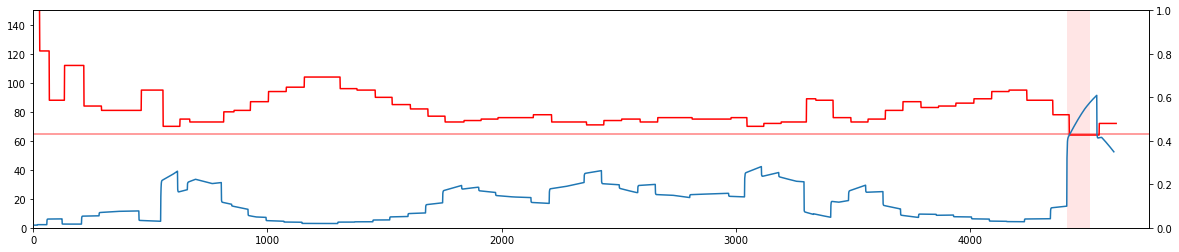

41/41 [==============================] - 1s 11ms/step
Print error: 5297	0.3166036931695142	


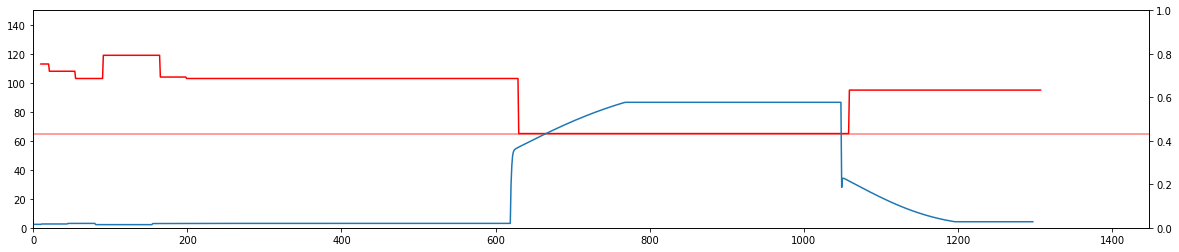

193/193 [==============================] - 2s 12ms/step
Print error: 5318	0.3968866684467389	


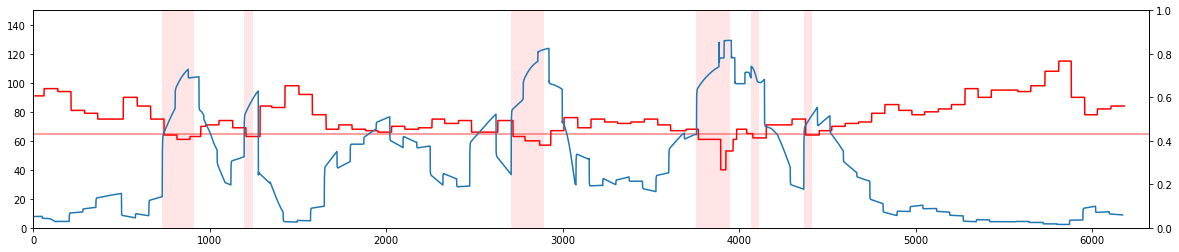

97/97 [==============================] - 1s 11ms/step
Print error: 5345	0.3050153264705295	


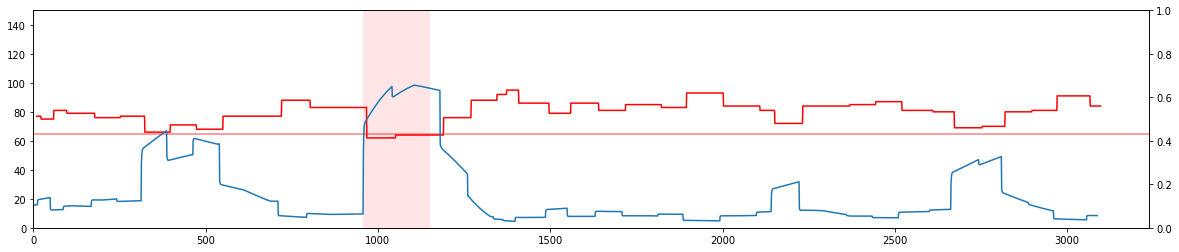

261/261 [==============================] - 3s 10ms/step
Print error: 5400	0.2796042957894447	


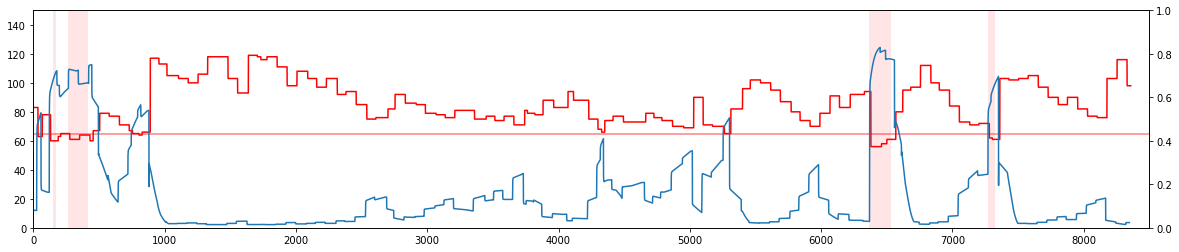

186/186 [==============================] - 2s 10ms/step
Print error: 5465	0.2704515915160022	


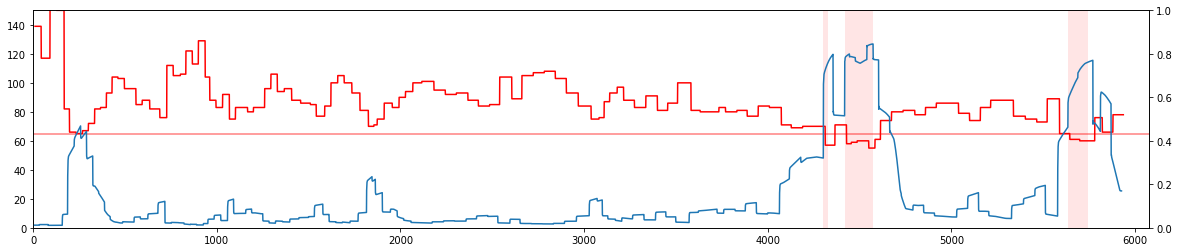

185/185 [==============================] - 2s 10ms/step
Print error: 5494	0.4511561535494768	


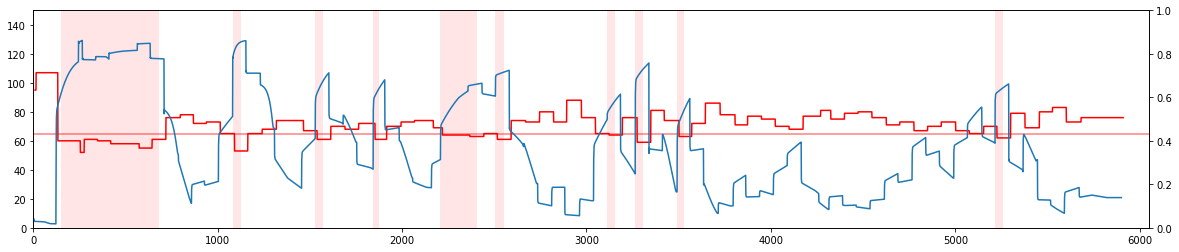

115/115 [==============================] - 1s 11ms/step
Print error: 5523	0.14589738858214868	


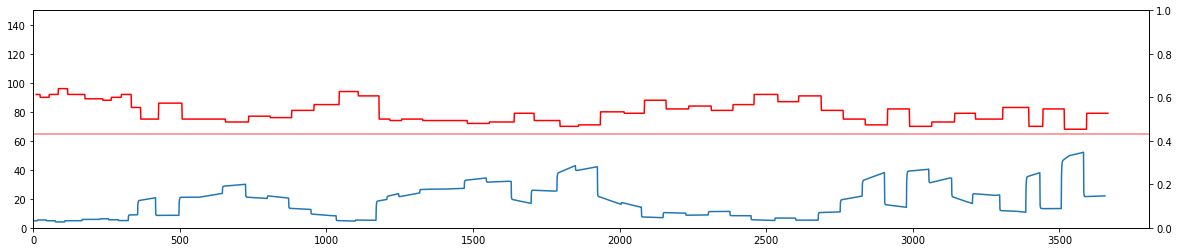

123/123 [==============================] - 1s 10ms/step
Print error: 5555	0.39602256526498403	


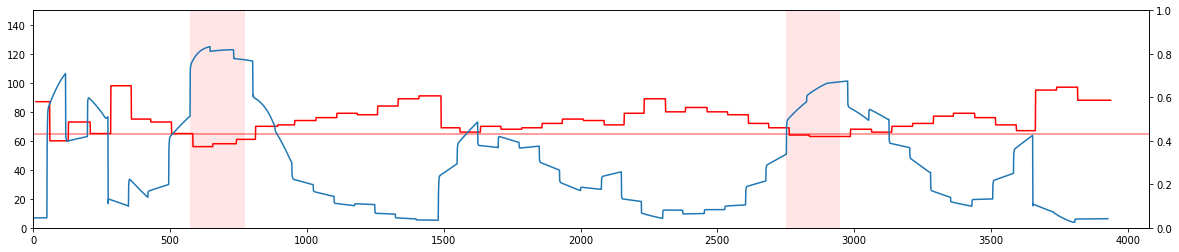

113/113 [==============================] - 1s 11ms/step
Print error: 5631	0.2763345382330164	


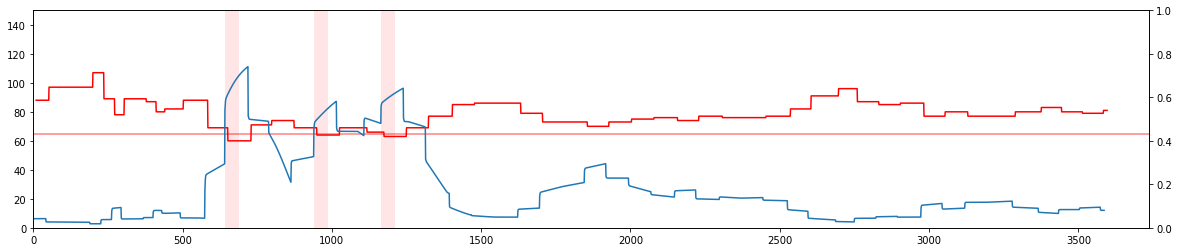

152/152 [==============================] - 2s 13ms/step
Print error: 5644	0.13956527634680874	


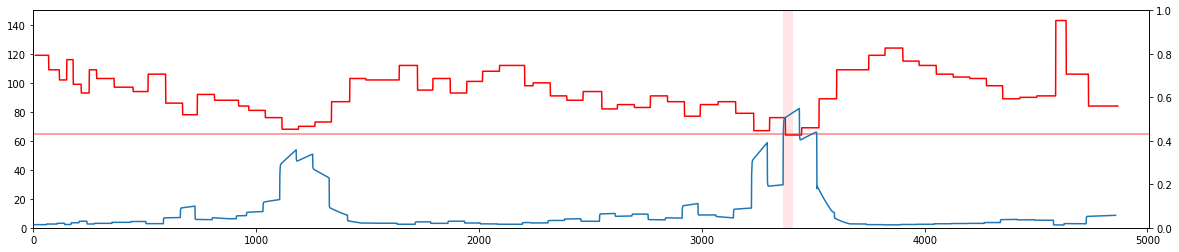

126/126 [==============================] - 2s 12ms/step
Print error: 5731	0.12630804939205806	


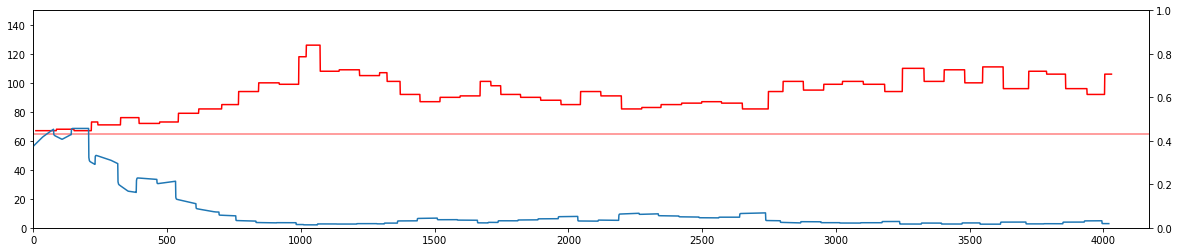

181/181 [==============================] - 2s 12ms/step
Print error: 5734	0.09030214279177394	


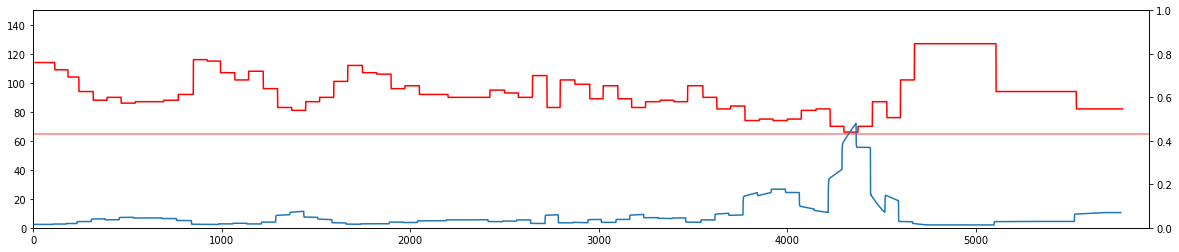

204/204 [==============================] - 2s 11ms/step
Print error: 5756	0.18307469427259568	


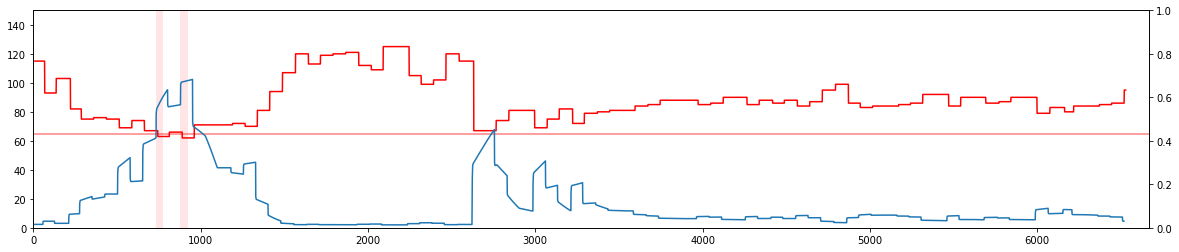

183/183 [==============================] - 2s 10ms/step
Print error: 5798	0.3827043692013696	


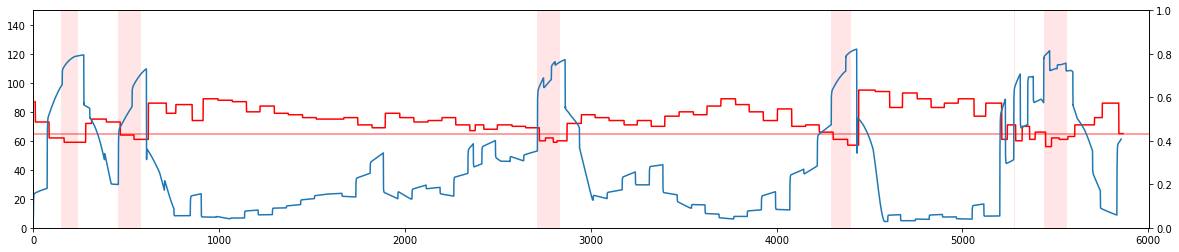

121/121 [==============================] - 1s 12ms/step
Print error: 5828	0.2871355447065978	


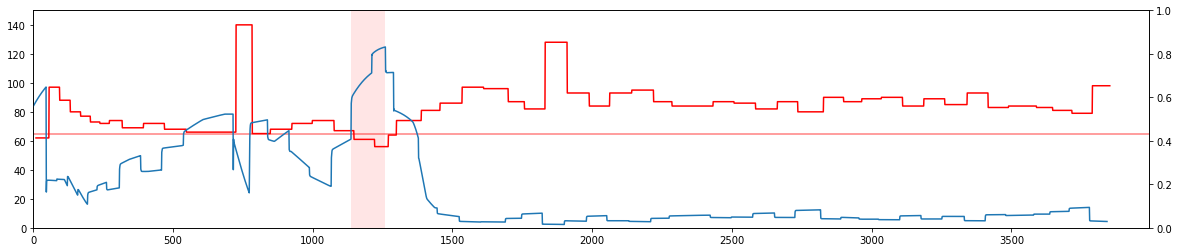

69/69 [==============================] - 1s 11ms/step
Print error: 5834	0.10271680503984885	


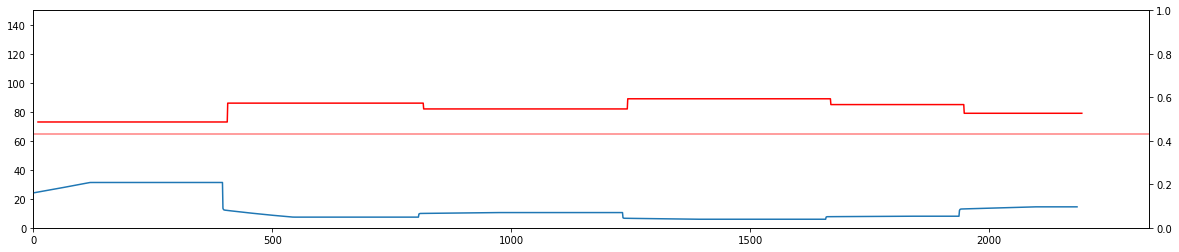

165/165 [==============================] - 2s 10ms/step
Print error: 5881	0.47765049482627625	


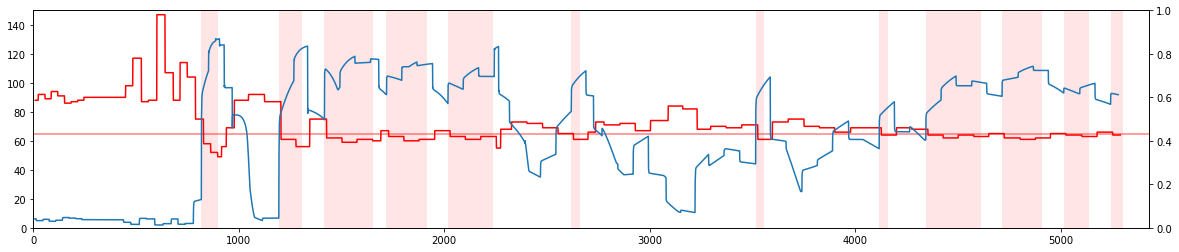

11/11 [==============================] - 0s 22ms/step
Print error: 5888	0.016969086404127944	


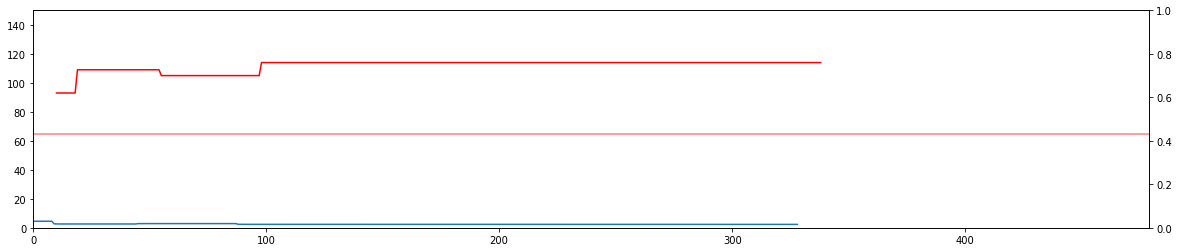

173/173 [==============================] - 3s 15ms/step
Print error: 5900	0.2199949448042645	


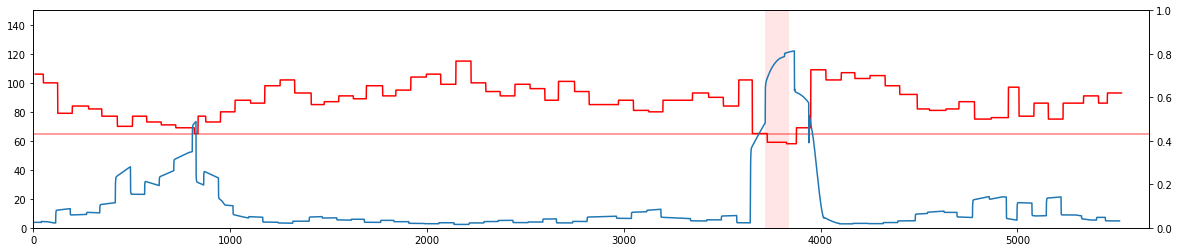

183/183 [==============================] - 3s 14ms/step
Print error: 5935	0.048916512599316044	


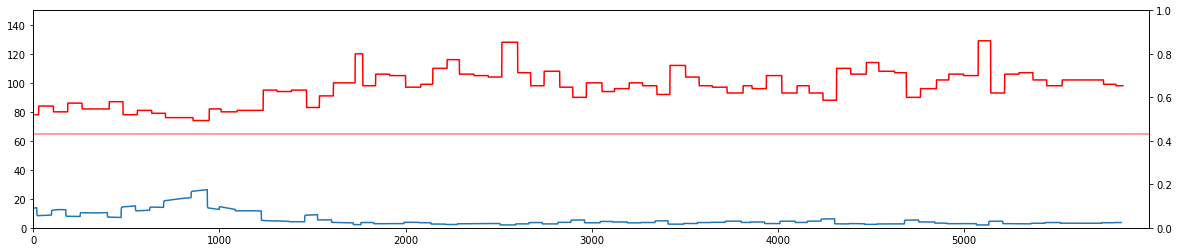

178/178 [==============================] - 2s 13ms/step
Print error: 6001	0.2487441048330927	


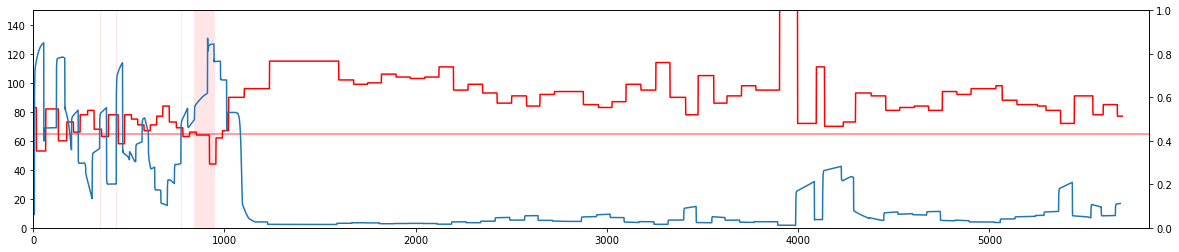

278/278 [==============================] - 3s 12ms/step
Print error: 6112	0.2892902224747007	


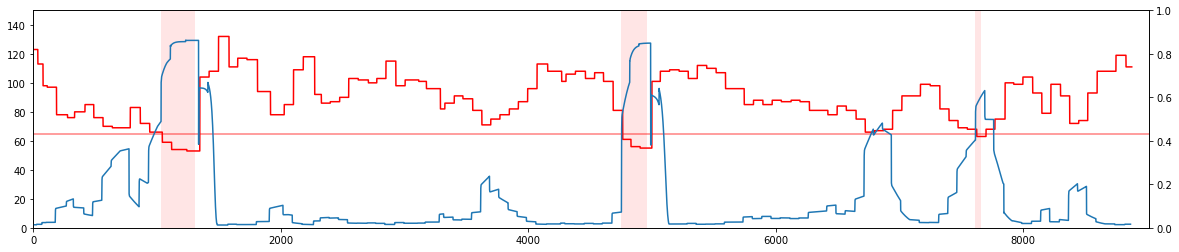

62/62 [==============================] - 1s 11ms/step
Print error: 6118	0.39148824674251975	


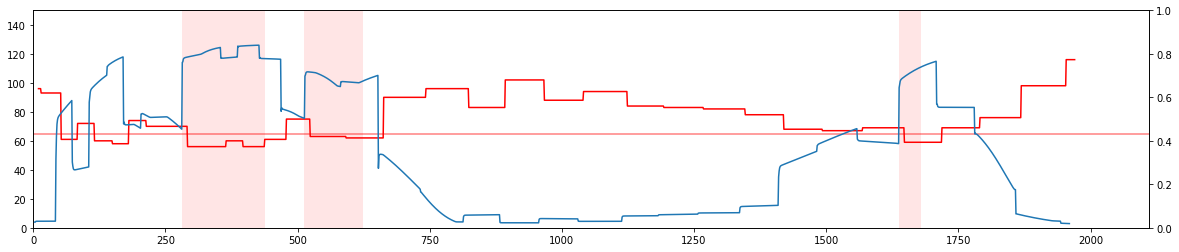

133/133 [==============================] - 1s 10ms/step
Print error: 6123	0.1758106419044377	


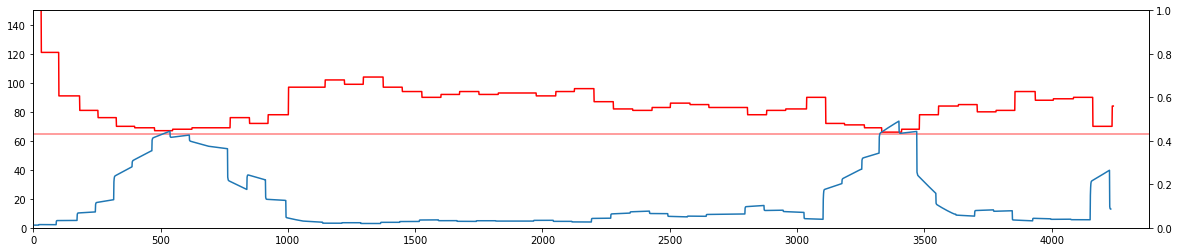

168/168 [==============================] - 2s 13ms/step
Print error: 6225	0.23259067816745047	


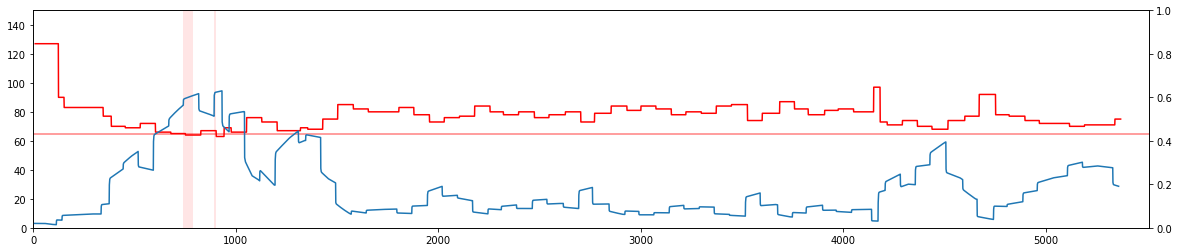

132/132 [==============================] - 2s 14ms/step
Print error: 6226	0.43104904509888725	


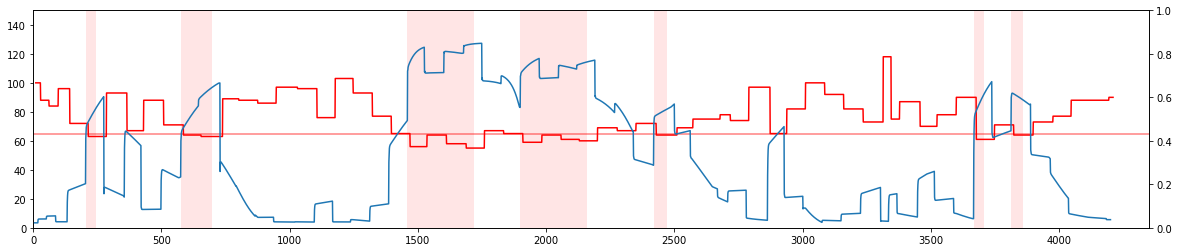

99/99 [==============================] - 1s 14ms/step
Print error: 6263	0.10755664867320808	


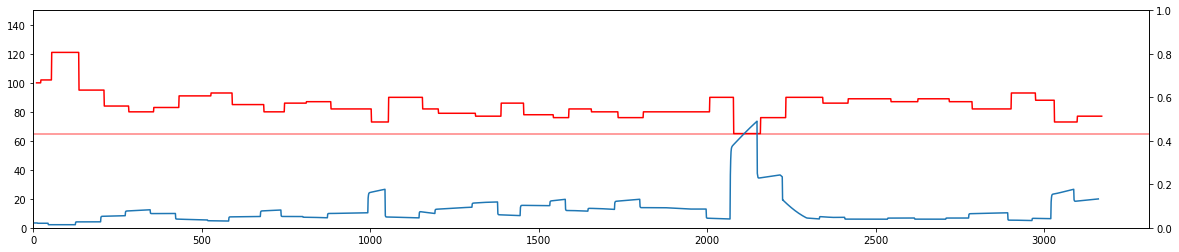

65/65 [==============================] - 1s 15ms/step
Print error: 6265	0.3160407463056977	


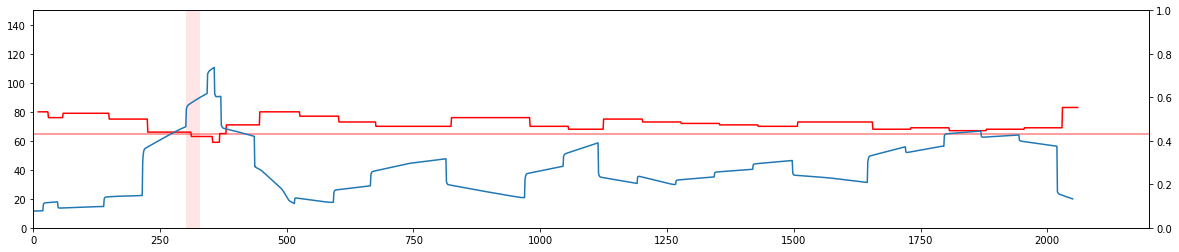

124/124 [==============================] - 1s 10ms/step
Print error: 6325	0.20060357124947276	


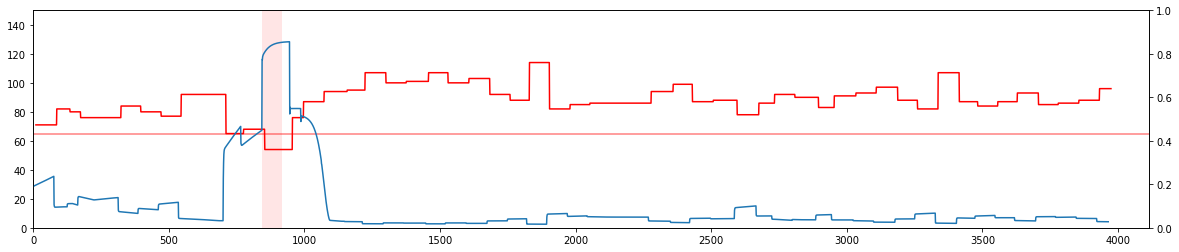

118/118 [==============================] - 1s 10ms/step
Print error: 6340	0.281123039941837	


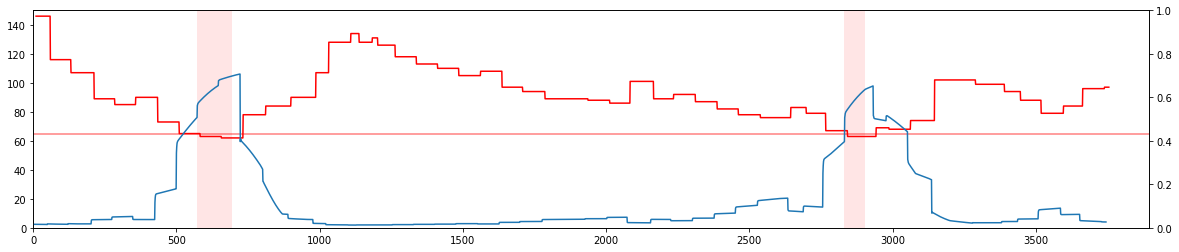

104/104 [==============================] - 1s 10ms/step
Print error: 6352	0.41523886863882337	


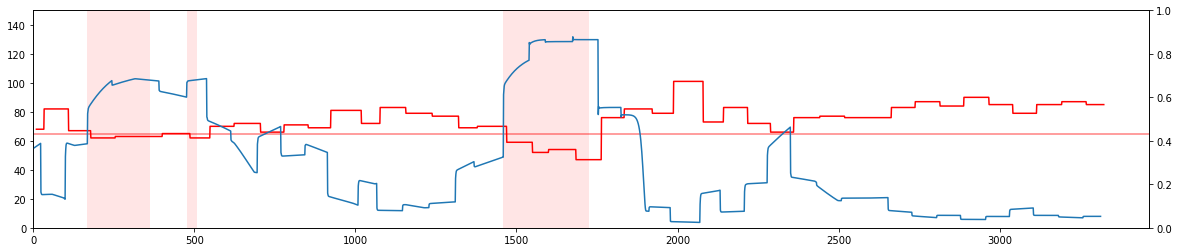

90/90 [==============================] - 1s 11ms/step
Print error: 6360	0.3975161202478883	


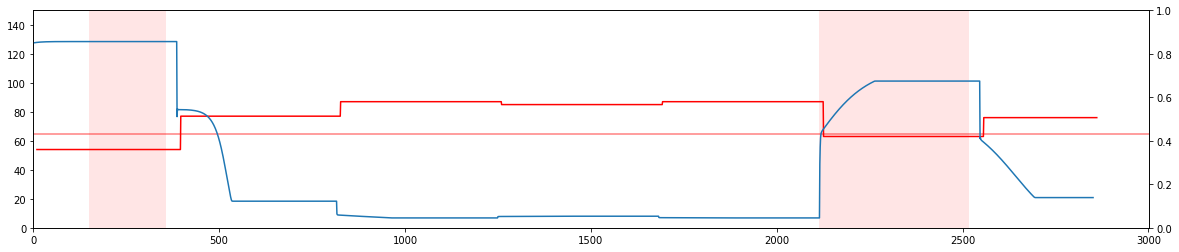

In [19]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('Print error:', '{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()